Epoch 1/100, Training Loss: 0.012788, Validation Loss: 0.004785
Epoch 2/100, Training Loss: 0.000715, Validation Loss: 0.002224
Epoch 3/100, Training Loss: 0.000450, Validation Loss: 0.002445
Epoch 4/100, Training Loss: 0.000270, Validation Loss: 0.002168
Epoch 5/100, Training Loss: 0.000204, Validation Loss: 0.001646
Epoch 6/100, Training Loss: 0.000284, Validation Loss: 0.001528
Epoch 7/100, Training Loss: 0.000234, Validation Loss: 0.002336
Epoch 8/100, Training Loss: 0.000131, Validation Loss: 0.001727
Epoch 9/100, Training Loss: 0.000137, Validation Loss: 0.002687
Epoch 10/100, Training Loss: 0.000166, Validation Loss: 0.002364
Epoch 11/100, Training Loss: 0.000163, Validation Loss: 0.002660
Epoch 12/100, Training Loss: 0.000139, Validation Loss: 0.001861
Epoch 13/100, Training Loss: 0.000150, Validation Loss: 0.000927
Epoch 14/100, Training Loss: 0.000178, Validation Loss: 0.001105
Epoch 15/100, Training Loss: 0.000163, Validation Loss: 0.001410
Epoch 16/100, Training Loss: 0.000

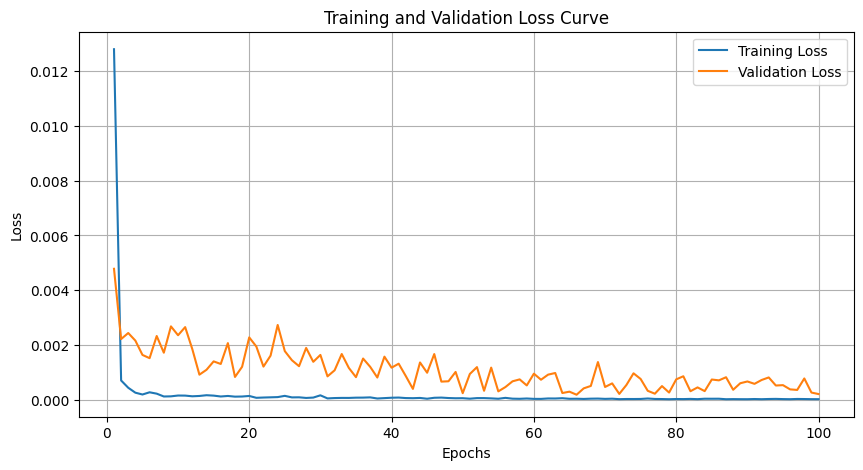

MAE: 248.9035, RMSE: 348.1498


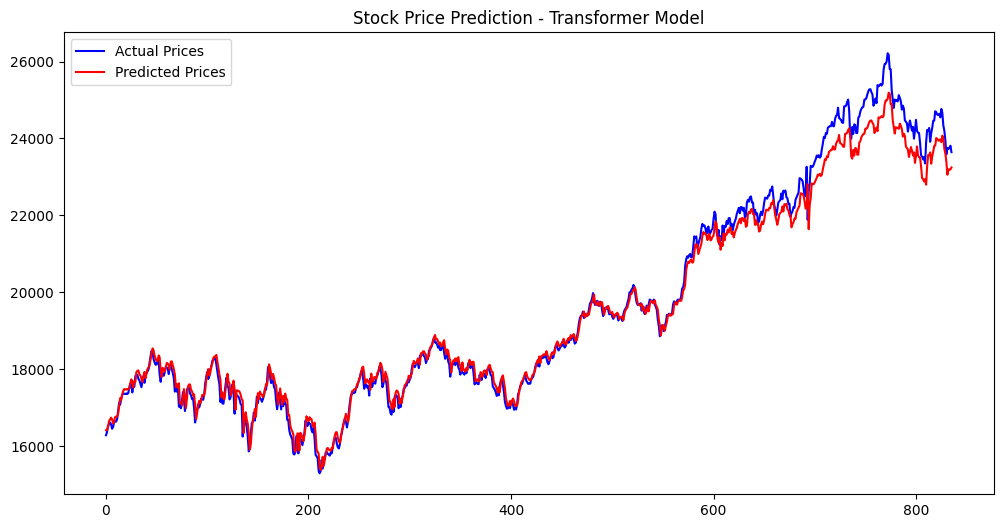

In [ ]:
# ==========================================
# 1. Import Libraries
# ==========================================
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import os

# ==========================================
# 2. Load and Preprocess Data
# ==========================================
data_path = os.path.join("..", "data", "Nifty50_Train_max.csv")
df = pd.read_csv(data_path)

# Convert date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select 'Close' price for prediction
data = df[['Close']].copy()

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Close'] = scaler.fit_transform(data[['Close']])

# Function to create sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length].values)
    return np.array(X), np.array(y)

seq_length = 60  # Use past 30 days
X, y = create_sequences(data, seq_length)

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ==========================================
# 3. Transformer Model Definition
# ==========================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v):
        batch_size = q.shape[0]
        q = self.W_q(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.W_k(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.W_v(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(self.d_k)
        attn_weights = self.softmax(scores)
        attn_output = torch.matmul(attn_weights, v)

        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.W_o(attn_output)

class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, hidden_dim, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(nn.Linear(d_model, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, d_model))
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_out = self.attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_out))
        ffn_out = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_out))
        return x

class TransformerTimeSeries(nn.Module):
    def __init__(self, input_dim, d_model, num_heads, hidden_dim, num_layers, seq_len):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.encoder_layers = nn.ModuleList([TransformerEncoderBlock(d_model, num_heads, hidden_dim) for _ in range(num_layers)])
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.pos_encoding(x)
        for layer in self.encoder_layers:
            x = layer(x)
        x = self.output_layer(x[:, -1, :])
        return x

# ==========================================
# 4. Model Training & Validation
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerTimeSeries(input_dim=1, d_model=64, num_heads=4, hidden_dim=128, num_layers=2, seq_len=seq_length)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_val_pred = model(X_val)
            val_loss += criterion(y_val_pred, y_val).item()

    val_losses.append(val_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_losses[-1]:.6f}, Validation Loss: {val_losses[-1]:.6f}")


# ==========================================
# 6. Plot Training & Validation Loss Curves
# ==========================================
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid()
plt.show()


# ==========================================
# 5. Predictions & Evaluation
# ==========================================
model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

predictions = scaler.inverse_transform(np.concatenate(predictions).flatten().reshape(-1, 1)).flatten()
actuals = scaler.inverse_transform(np.concatenate(actuals).flatten().reshape(-1, 1)).flatten()

mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# ==========================================
# 6. Plot Results
# ==========================================
plt.figure(figsize=(12,6))
plt.plot(actuals, label="Actual Prices", color='blue')
plt.plot(predictions, label="Predicted Prices", color='red')
plt.legend()
plt.title("Stock Price Prediction - Transformer Model")
plt.show()
